# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Problem statement
we need to predict purchasing offers to most response customer (offer _received , offer viewed , offer complete ) based on demographic attributes of customer and other attributes of company offers


## Project Metrics
I will use accuracy and F-score metrics for comparison and to test out the performance of the models.
according to score of F1 for test and train for 3 clustering we user we judge the and choose which model will be the best

### importing Libraries
starting by uploading necessary data

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import seaborn as sns 
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Reading Files
and then reading 3 files of data we have.

* portfolio
* profile
* transcript

In [2]:
portfolio.shape  , profile.shape  , transcript.shape 

((10, 6), (17000, 5), (306534, 4))

 ### portfolio dataset 

In [3]:
#explore data
portfolio.head(11)  #as shape of data is (10,6)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [5]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

#### Cleaning up of this portfolio dataset 
1-  changing the name of id to offer_id  as we need to  make it as primamry key and we will use use it to join other dataset.

2- making a one hot encoded with channel and sperate every channel .

3- making one hot encoding to offer_type  and drop offer type


In [6]:
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

In [7]:
dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, dummy], axis=1)

In [8]:
#One hot encoding the offer_type field, fixing a prefix of 'offer'
dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
portfolio = pd.concat([portfolio, dummies], axis = 1)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


### porofile dataset 

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


**check how many null in my dataset**

In [11]:
profile[profile['income'].isnull()].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

**drop the null data**

In [12]:
profile.dropna(inplace=True)

In [13]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


 **making some exploration of data** 



In [14]:
#Age Column
profile[profile.age >= 118].count()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

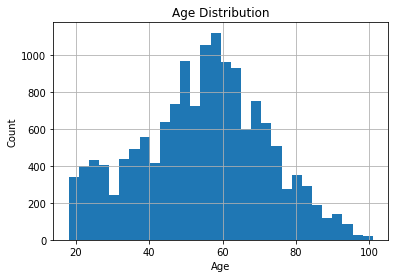

In [15]:
profile.age.hist(bins = 30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution');

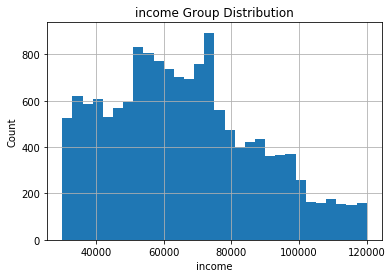

In [16]:
# distribution of income
profile.income.hist(bins = 30)
plt.xlabel('income')
plt.ylabel('Count')
plt.title('income Group Distribution');

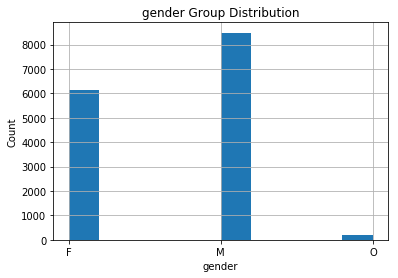

In [17]:
profile.gender.hist()
plt.xlabel('gender')
plt.ylabel('Count')
plt.title('gender Group Distribution');

#### Cleaning up of this profile dataset :

1- removing outlier from age .

2- change "became_member_on" datatype to be datetime .

3- changing column id to customer_id .
 
4- check null information and drop column with null .

5- create  age_range from age 

6- create days_as_member from become a member   

In [18]:
# Remove outliers (age 118)
remove = profile[profile.age == 105]
profile = profile[profile.age < 105].reset_index(drop=True)

In [19]:
# Convert  became_member_on to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [20]:
profile.rename(columns={'id':'customer_id'},inplace=True)

In [21]:
end_date = pd.Timestamp('2018-08-01')
end_date = pd.to_datetime(end_date)
profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)
profile['days_as_member']

0         382
1         449
2          97
3         173
4         263
5         324
6        1630
7         902
8        1357
9         213
10         92
11        819
12        326
13        411
14       1816
15         95
16        309
17        324
18       1288
19       1439
20        319
21        310
22        257
23        753
24        717
25       1543
26        354
27        993
28        751
29         25
         ... 
14795     566
14796     115
14797     114
14798    1283
14799    1132
14800     372
14801     998
14802      71
14803     559
14804    1024
14805     931
14806     213
14807     679
14808     527
14809    1774
14810     763
14811    1215
14812     746
14813      43
14814     366
14815     753
14816     209
14817     874
14818     318
14819      88
14820      58
14821      19
14822     552
14823     877
14824     375
Name: days_as_member, Length: 14825, dtype: int64

In [22]:
age_range_labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','90-99','+100']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 90, 100 , 110]
profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_labels, right = False)


In [23]:
profile['age_range'] = pd.Categorical(profile['age_range'], ordered = True, categories = age_range_labels)
profile['age_range'].isnull().sum()

0

In [24]:
profile['gender'].value_counts

<bound method IndexOpsMixin.value_counts of 0        F
1        F
2        M
3        M
4        M
5        F
6        M
7        F
8        M
9        M
10       F
11       F
12       M
13       F
14       M
15       F
16       F
17       F
18       M
19       M
20       O
21       M
22       F
23       M
24       F
25       M
26       F
27       M
28       F
29       M
        ..
14795    F
14796    M
14797    M
14798    M
14799    M
14800    M
14801    M
14802    F
14803    F
14804    M
14805    F
14806    F
14807    F
14808    F
14809    F
14810    M
14811    F
14812    F
14813    M
14814    F
14815    M
14816    M
14817    F
14818    F
14819    M
14820    F
14821    M
14822    M
14823    F
14824    F
Name: gender, Length: 14825, dtype: object>

## transcript dataset

In [25]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [26]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
#check null values 
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

#### Cleaning up of this transcript  dataset :

1- change a person to Customer_id  .

2- change value to be "offer id " and remove str bepfre it  .
 
3- make one hot code for event value.

4- change time to days 
  

In [28]:
#Changing the column name from 'id' to 'offer_id'
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event          306534 non-null object
customer_id    306534 non-null object
time           306534 non-null int64
value          306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [29]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [30]:
transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]

In [31]:
transcript.head()

,event,customer_id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [32]:
event_dummies = pd.get_dummies(transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript = pd.concat([transcript, event_dummies], axis = 1)
transcript.head()

,event,customer_id,time,value,offer_id,offer_completed,offer_received,offer_viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [33]:
transcript['days'] = transcript['time'] / 24
transcript.drop(columns = ['time'], inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
event              306534 non-null object
customer_id        306534 non-null object
value              306534 non-null object
offer_id           167581 non-null object
offer_completed    306534 non-null uint8
offer_received     306534 non-null uint8
offer_viewed       306534 non-null uint8
transaction        306534 non-null uint8
days               306534 non-null float64
dtypes: float64(1), object(4), uint8(4)
memory usage: 12.9+ MB


In [34]:
transcript.sample(5)

,event,customer_id,value,offer_id,offer_completed,offer_received,offer_viewed,transaction,days
196521,transaction,9da33731c69f4d838d8dacc2f041d538,{'amount': 3.37},None,0,0,0,1,20.00
131522,transaction,beac80ebf5c84f278be6412ee2b52ddd,{'amount': 20.16},None,0,0,0,1,14.50
271514,transaction,eb1292b2a19245b48180e0f6c96fdc6d,{'amount': 23.81},None,0,0,0,1,24.75
245629,offer received,c92ad69c3da742279ca04720545955e0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,0,24.00
33602,offer completed,28ae5599449d43288b3e0983080ad04c,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,2.50


## Data Exploration 
Trying to generate question and its answer from data point of view

**what is distribution of customer range of age ?**

customer age take the bell curve for the age range what is called normal distribution mean = median = mode

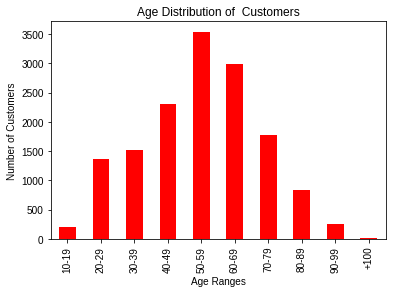

In [35]:
#Viewing the age ranges of our Starbucks customers
profile['age_range'].value_counts().sort_index().plot(kind = 'bar', color = 'red');
plt.title('Age Distribution of  Customers');
plt.style.use('seaborn');
plt.ylabel('Number of Customers');
plt.xlabel('Age Ranges');

**what the distribution of income with age_range ?**


it shows that :
for young age range income is low and range of icome not hight and  thus understood , also income increase by age_range increae also range of icome increase untill reach to the age range more than 100 years old 

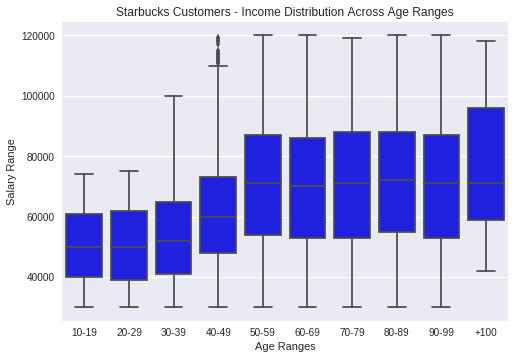

In [36]:

sns.boxplot(data = profile, x = 'age_range', y = 'income', color = 'blue');
plt.title('Starbucks Customers - Income Distribution Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

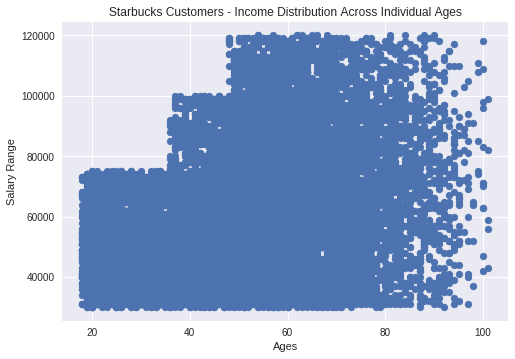

In [37]:
#Visualizing the data in a scatter plot using individual ages instead of age ranges
plt.scatter(data = profile, x = 'age', y = 'income');
plt.title('Starbucks Customers - Income Distribution Across Individual Ages');
plt.xlabel('Ages');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

**at what age range they will keen to keep their member ship ?**

we found approximatly all is the same  

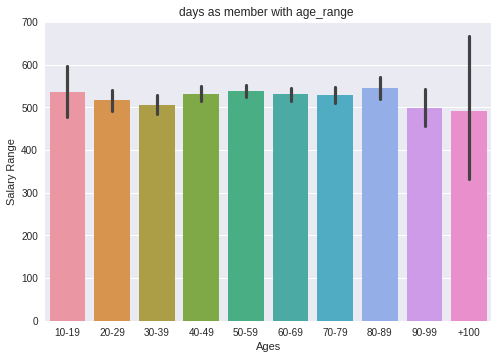

In [38]:
#Visiualizing the data in a violin plot
sns.color_palette()
#Visualizing the data in a scatter plot using individual ages instead of age ranges
sns.barplot(data = profile, y = 'days_as_member', x = 'age_range');
plt.title('days as member with age_range ');
plt.xlabel('Ages');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

**what is the age distribution across gender ?**

we found male is higher at all ranges excepted ranges after 80 years old 
 and second plot shows all income vs age reange by consider gender it show higher income for mid age range for female and other is male 

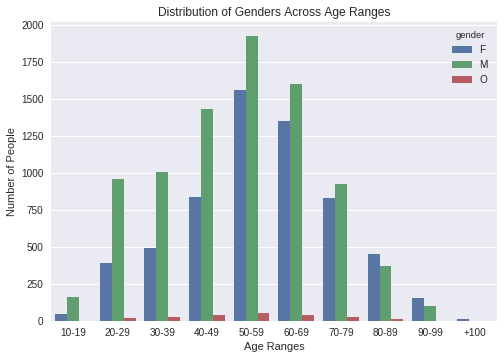

In [39]:
#Visualizing the gender distribution in a seaborn count plot
sns.countplot(data = profile, x = 'age_range', hue = 'gender');
plt.title('Distribution of Genders Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Number of People');
plt.style.use('seaborn');

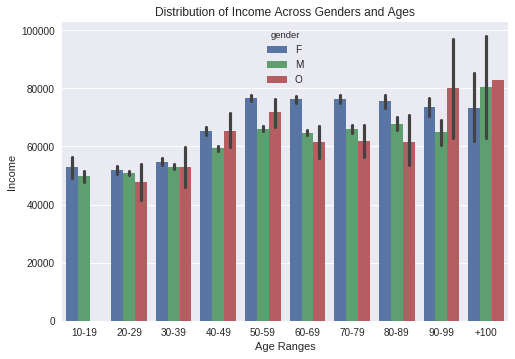

In [40]:
#Visualizing the gender/income/age range distribution in a seaborn bar plot
sns.barplot(data = profile , x = 'age_range', y = 'income', hue = 'gender');
plt.title('Distribution of Income Across Genders and Ages');
plt.xlabel('Age Ranges');
plt.ylabel('Income');
plt.style.use('seaborn');

In [41]:
profile.head()

,age,became_member_on,gender,customer_id,income,days_as_member,age_range
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,382,50-59
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,449,70-79
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,97,60-69
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,173,60-69
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,263,50-59


## merging dataset in master dataset 

In [42]:
master0  = pd.merge(transcript  ,portfolio ,on='offer_id')
master0.head()

,event,customer_id,value,offer_id,offer_completed,offer_received,offer_viewed,transaction,days,channels,...,duration,offer_type,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,7,bogo,5,1,1,0,1,1,0,0
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,7,bogo,5,1,1,0,1,1,0,0
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,7,bogo,5,1,1,0,1,1,0,0
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,7,bogo,5,1,1,0,1,1,0,0
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,7,bogo,5,1,1,0,1,1,0,0


In [43]:
master1  = pd.merge(master0  ,profile , how='left',on='customer_id')
master1.head()

,event,customer_id,value,offer_id,offer_completed,offer_received,offer_viewed,transaction,days,channels,...,web,offer_bogo,offer_discount,offer_informational,age,became_member_on,gender,income,days_as_member,age_range
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,1,0,0,75.0,2017-05-09,F,100000.0,449.0,70-79
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,1,0,0,59.0,2015-01-21,M,41000.0,1288.0,50-59
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,1,0,0,40.0,2016-07-09,M,33000.0,753.0,40-49
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,1,0,0,45.0,2018-07-07,M,33000.0,25.0,40-49
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,1,0,0,54.0,2017-02-07,F,80000.0,540.0,50-59


In [44]:
master = master1.copy ()

In [45]:
#split transcript into 3 different offer types
bogo = master[master['offer_type']=='bogo'].copy()
discount = master[master['offer_type']=='discount'].copy()
informational = master[master['offer_type']== 'informational'].copy()

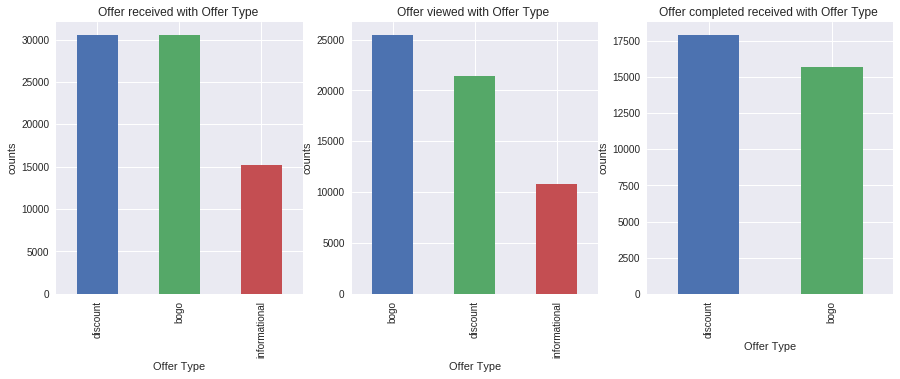

In [46]:
plt.subplot(131)
offer_received = master[master['offer_received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

plt.subplot(132)
offer_viewed = master[master['offer_viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');

plt.subplot(133)
offer_completed = master[master['offer_completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');

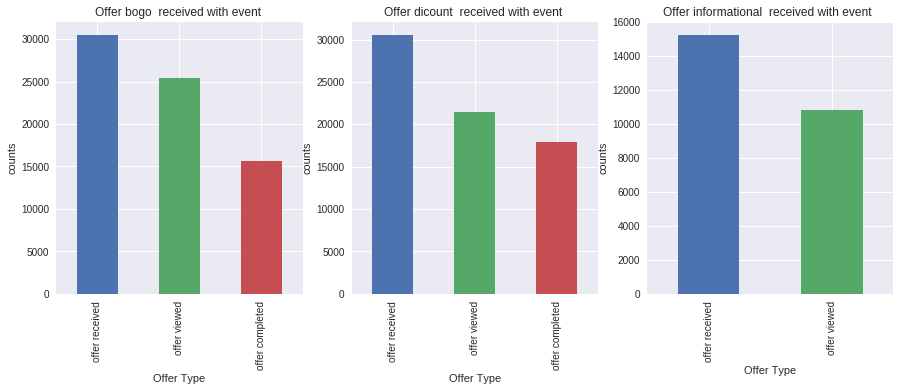

In [47]:
plt.subplot(131)
offer_received = master[master['offer_bogo'] == 1].event.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer bogo  received with event ');

plt.subplot(132)
offer_viewed = master[master['offer_discount'] == 1].event.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer dicount  received with event ');

plt.subplot(133)
offer_completed = master[master['offer_informational'] == 1].event.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer informational  received with event  ');

In [48]:
offer_id = master['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [49]:
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 2: '2906b810c7d4411798c6938adc9daaa5',
 3: 'fafdcd668e3743c1bb461111dcafc2a4',
 4: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 5: 'f19421c1d4aa40978ebb69ca19b0e20d',
 6: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 7: '3f207df678b143eea3cee63160fa8bed',
 8: 'ae264e3637204a6fb9bb56bc8210ddfd',
 9: '5a8bc65990b245e5a138643cd4eb9837'}

In [50]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
 '2906b810c7d4411798c6938adc9daaa5': 2,
 'fafdcd668e3743c1bb461111dcafc2a4': 3,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 4,
 'f19421c1d4aa40978ebb69ca19b0e20d': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 '3f207df678b143eea3cee63160fa8bed': 7,
 'ae264e3637204a6fb9bb56bc8210ddfd': 8,
 '5a8bc65990b245e5a138643cd4eb9837': 9}

In [51]:

master['offer_id0'] = master['offer_id'].map(offer_dict)
master.head()

,event,customer_id,value,offer_id,offer_completed,offer_received,offer_viewed,transaction,days,channels,...,offer_bogo,offer_discount,offer_informational,age,became_member_on,gender,income,days_as_member,age_range,offer_id0
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,0,0,75.0,2017-05-09,F,100000.0,449.0,70-79,0
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,0,0,59.0,2015-01-21,M,41000.0,1288.0,50-59,0
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,0,0,40.0,2016-07-09,M,33000.0,753.0,40-49,0
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,0,0,45.0,2018-07-07,M,33000.0,25.0,40-49,0
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,0.0,"[web, email, mobile]",...,1,0,0,54.0,2017-02-07,F,80000.0,540.0,50-59,0


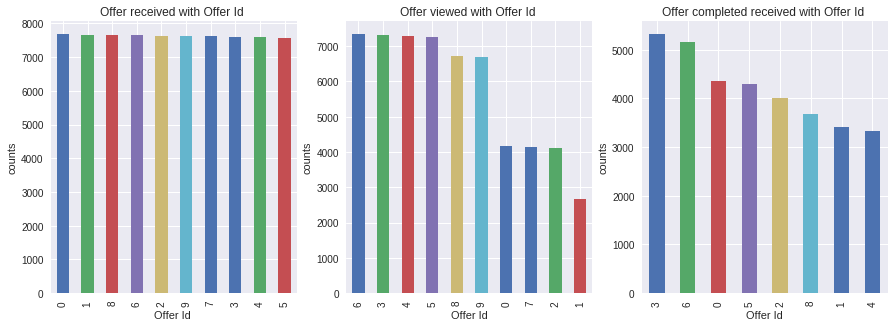

In [52]:
plt.subplot(131)
offer_received = master[master['offer_received'] == 1].offer_id0.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received with Offer Id ');

plt.subplot(132)
offer_viewed = master[master['offer_viewed'] == 1].offer_id0.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed with Offer Id ');

plt.subplot(133)
offer_completed = master[master['offer_completed'] == 1].offer_id0.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed received with Offer Id ');

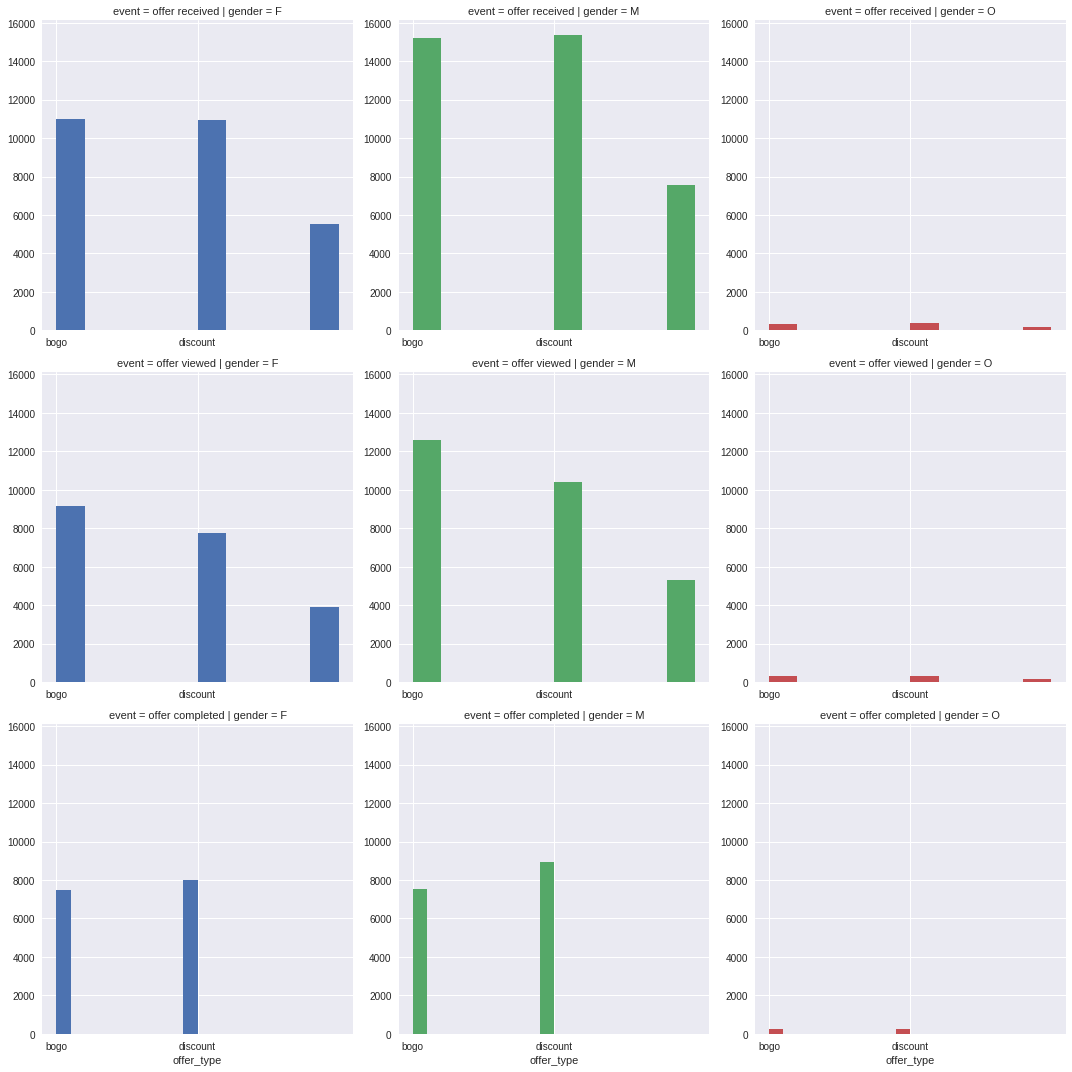

In [53]:
g = sns.FacetGrid(master, row='event', col='gender', hue='gender', size=5)
g.map(plt.hist, 'offer_type')

In [54]:
master['offer_id'] = master['value'].apply(lambda x: x.get('offer_id'))
master['money_gained'] = master['value'].apply(lambda x: x.get('reward'))
master['money_spent'] = master['value'].apply(lambda x: x.get('amount'))

In [55]:
master['month_member'] = master['became_member_on'].apply(lambda x: x.month)
master['year_member'] = master['became_member_on'].apply(lambda x: x.year)

### prepare data for machine learning model 

In [56]:
### i will choose some of these column which will assist in bulding model 

In [57]:
master_model = master.drop(['offer_id', 'channels' , 'offer_type', 'value' ], axis=1)

In [58]:
master_model.head()

,event,customer_id,offer_completed,offer_received,offer_viewed,transaction,days,difficulty,duration,reward,...,became_member_on,gender,income,days_as_member,age_range,offer_id0,money_gained,money_spent,month_member,year_member
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0.0,5,7,5,...,2017-05-09,F,100000.0,449.0,70-79,0,NaN,None,5.0,2017.0
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,1,0,0,0.0,5,7,5,...,2015-01-21,M,41000.0,1288.0,50-59,0,NaN,None,1.0,2015.0
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,1,0,0,0.0,5,7,5,...,2016-07-09,M,33000.0,753.0,40-49,0,NaN,None,7.0,2016.0
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,1,0,0,0.0,5,7,5,...,2018-07-07,M,33000.0,25.0,40-49,0,NaN,None,7.0,2018.0
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,1,0,0,0.0,5,7,5,...,2017-02-07,F,80000.0,540.0,50-59,0,NaN,None,2.0,2017.0


In [59]:
master_model1 =  master_model[['transaction', 'income'  , 'offer_discount', 'offer_informational' 
                                ,'days' ,'reward', 'difficulty'  , 'event','gender','duration' ,'money_spent' , 'money_gained'	,'email'   ,'mobile', 'social'  , 'web', 'offer_bogo'  ,'income'   ,'days_as_member',   'offer_id0' , 'month_member', 'year_member'  ]]

master_model1.head()

,transaction,income,offer_discount,offer_informational,days,reward,difficulty,event,gender,duration,...,email,mobile,social,web,offer_bogo,income,days_as_member,offer_id0,month_member,year_member
0,0,100000.0,0,0,0.0,5,5,offer received,F,7,...,1,1,0,1,1,100000.0,449.0,0,5.0,2017.0
1,0,41000.0,0,0,0.0,5,5,offer received,M,7,...,1,1,0,1,1,41000.0,1288.0,0,1.0,2015.0
2,0,33000.0,0,0,0.0,5,5,offer received,M,7,...,1,1,0,1,1,33000.0,753.0,0,7.0,2016.0
3,0,33000.0,0,0,0.0,5,5,offer received,M,7,...,1,1,0,1,1,33000.0,25.0,0,7.0,2018.0
4,0,80000.0,0,0,0.0,5,5,offer received,F,7,...,1,1,0,1,1,80000.0,540.0,0,2.0,2017.0


In [60]:
master_model1['event'] = master_model1['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
master_model1['gender'] = master_model1['gender'].map({'M':1, 'F':2, 'O':3})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
 master_model1.sample()

,transaction,income,offer_discount,offer_informational,days,reward,difficulty,event,gender,duration,...,email,mobile,social,web,offer_bogo,income,days_as_member,offer_id0,month_member,year_member
116795,0,NaN,1,0,21.0,3,7,1,NaN,7,...,1,1,1,1,0,NaN,NaN,6,NaN,NaN


In [63]:
master_model1['income'] = master_model1['income'].fillna(method="ffill")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
master_model2 = master_model1.dropna(axis=1)

In [65]:
master_model2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 16 columns):
transaction            167581 non-null uint8
income                 167581 non-null float64
offer_discount         167581 non-null uint8
offer_informational    167581 non-null uint8
days                   167581 non-null float64
reward                 167581 non-null int64
difficulty             167581 non-null int64
event                  167581 non-null int64
duration               167581 non-null int64
email                  167581 non-null uint8
mobile                 167581 non-null uint8
social                 167581 non-null uint8
web                    167581 non-null uint8
offer_bogo             167581 non-null uint8
income                 167581 non-null float64
offer_id0              167581 non-null int64
dtypes: float64(3), int64(5), uint8(8)
memory usage: 12.8 MB


In [66]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['difficulty', 'reward','duration', 'days' , 'income']
master_model2[numerical] = scaler.fit_transform(master_model2[numerical])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [67]:
data = master_model2.drop('event', axis=1)
label = master_model2['event']

In [68]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 100548 rows
Testing set: 67033 rows


In [69]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

In [70]:
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [71]:

knn = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)

In [72]:
from sklearn.ensemble import RandomForestClassifier
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

In [73]:
from sklearn.tree import DecisionTreeClassifier
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

In [74]:
randomforest  = {'Benchmark Model': [ c_model], 'train F1 score':[c_train_f1], 'test F1 score': [c_test_f1]}


In [75]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comp = pd.DataFrame(models)

In [76]:
comp

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),75.874209,68.443901
1,RandomForestClassifier,84.319927,70.553310
2,DecisionTreeClassifier,85.085730,72.740292


### refinement :
trying to bring more balance data to the model which will achieve in get model to real case , i think data cleaning and sharing all features by correct weights will make the model more powerful and real
### Model Evaluation and Validation
we have evaluate the model by using F1 score for training and testing and according to the highest number of this test we can judge about the suitability of this model

### justification

The validation set (test data set) is used to evaluate the model. Both the models are better than the benchmark. The best score is created by the DecisionTreeClassifier model, as its validate F1 score is 85.10, which is much higher than the benchmark. The RandomForestClassifier model scores good as well compared to the benchmark, with a test F1 score of 75.87 . Our problem to solve is not that sensitive which requires very high F1 score, so the scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer.
Reflection

**What is the age distribution across gender with income ?**

we found male is higher at all ranges excepted ranges after 80 years old and second plot shows all income vs age range by consider gender it show higher income for mid age range for female and other is male

**What the distribution of income with age_range ?**

it shows that : for young age range income is low and range of income not height and thus understood , also income increase by age_range increase also range of income increase until reach to the age range more than 100 years old so we can pay attention to age range from 30and elder as income.

**what is distribution of Customer age range?**

customer age take the bell curve for the age range what is called normal distribution mean = median = mode. and this understood for age range

**How many offer type per each offer status ?**

it is appears that discount is the highest offer type all time, so we can keep offering discount as it highest among different categories


### Future Improvements

    there are more potentials to solving many queries and it can be utilized to answer many posed questions related customer interaction based on the Age and income as a whole too.
    Try different additional machine learning models.

# Final Discussion 
  i have used final  3  model  to classify the result we see that random forest classifier and decision tree approximatly the same 
  and KNeighborsClassifier  is the least 